Implement and test the 3 conditions of Schaal14 for shock detection

In [1]:
import Utilities.prelude
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import math
import k3match
from Utilities.operators import make_tree, calc_grad, calc_div

In [2]:
gamma = 5/3
mach_min = 1.3
save = True
snap = '683'
path = f'683'

In [3]:
def temperature_bump(mach, gamma):
    """ T_post/ T_pre shock according to RH conditions."""
    Tbump =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2)
    return Tbump

def pressure_bump(mach, gamma):
    """ P_post/ P_pre shock according to RH conditions."""
    Pbump = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1)
    return Pbump

def search_delta(X, Y, Z, point, dim_cell):
    x_point = point[0]
    y_point = point[1]
    z_point = point[2]

    _, _ , dist= k3match.cartesian(X, Y, Z, x_point, y_point, z_point, 2.5*dim_cell)
    delta = np.mean(dist)
    
    return delta

def shock_direction(sim_tree, X, Y, Z, Temp, point, delta):
    """ Find shock direction according eq.(5) by Schaal14 in the point of coordinates indices idx.
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Temp: arrays.
            Coordinates and temperature of the points of the tree.
    point: array.
            Starting point.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    grad: array.
        Gradient of temperature(vector of 3 components).
    ds: array.
        Shock direction (vector of 3 components).
    """
    grad = calc_grad(sim_tree, X, Y, Z, Temp, point, delta)
    magnitude = np.linalg.norm(grad)
    
    if np.logical_and(np.abs(grad[0])<1, np.logical_and(np.abs(grad[1])<1, np.abs(grad[2])<1)):
        ds = np.zeros(3)
    else:
        ds = - np.divide(grad,magnitude)
    return grad, ds
 
def find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction):
    """
    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose pre or post shock.
    Returns
    -----------
    new_point: array.
        Pre/post shock point
    """
    if direction == 'post':
        delta = - delta

    k = 1
    # check that you are not taking the same point as the one given
    distance = 0
    while distance == 0:
        new_point = point + k * delta * ds 
        _, idx  = sim_tree.query(new_point)
        check_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(point, check_point)
        k += 0.1

    return idx

def condition3(sim_tree, X, Y, Z, Press, Temp, point, ds, mach_min, gamma, delta):
    """ Last condition fot shock zone by Schaal14 .
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Press, Temp: arrays.
            Coordinates, pressure and temperature of the points of the tree.
    point: array.
            Starting point.
    ds: array (1x3)
        Shock direction.
    mach_min, gamma: floats.
                    Minimum mach number, adiabatic index.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    bool.
        If condition is satisfied or not.
    """
    # Find (the index in the tree of) the point in the pre/post shock region.
    idxpost = find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction = 'post') 
    idxpre = find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction = 'pre') 

    # Store data from the tree
    Tpost = Temp[idxpost]
    Ppost = Press[idxpost]
    Tpre = Temp[idxpre]
    Ppre = Press[idxpre]

    # Last condition fot shock zone by Schaal14
    delta_logT = np.log(Tpost) - np.log(Tpre)
    Tjump = temperature_bump(mach_min, gamma)
    Tjump = np.log(Tjump)
    ratioT = delta_logT / Tjump 
    delta_logP = np.log(Ppost)-np.log(Ppre)
    Pjump = pressure_bump(mach_min, gamma)
    Pjump = np.log(Pjump)
    ratioP = delta_logP / Pjump 
    
    if np.logical_and(ratioT >= 1, ratioP >= 1): 
        return True
    else:
        return False
    
def shock_zone(divv, gradT, gradrho, cond3, check_cond = '3'):
    """ Find the shock zone according conditions in Sec. 2.3.2 of Schaal14. 
    In order to test the code, with "check_con" you can decide if checking all or some of the conditions."""
    if check_cond == '1' or check_cond == '2':
        cond3 = True # so you don't check it
        if check_cond == '2':
            cond2 = np.dot(gradT, gradrho)
        else:
            cond2 = 10
    else:
        cond2 = np.dot(gradT, gradrho)

    if np.logical_and(divv<0, np.logical_and(cond2 > 0, cond3 == True)):
        return True
    else:
        return False

In [4]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

In [5]:
#choice = 'MEAN'
#step_grad = 2 * np.mean(dim_cell)
#step_zone = 2 * np.min(dim_cell)

In [6]:
#print('The step for grad is ', step_grad)

In [7]:
shock_dirx = []
shock_diry = []
shock_dirz = []
X_shock1 = []
Y_shock1 = []
Z_shock1 = []
X_shock2 = []
Y_shock2 = []
Z_shock2 = []
X_shock = []
Y_shock = []
Z_shock = []
div_shock = []
T_shock = []
are_u_shock = np.zeros(len(X), dtype = bool)
x_who = []
y_who = []
z_who = []
idx_tree = []

masked = 0
for i in range(len(X)):
    # print(i)
    point = np.array([X[i],Y[i],Z[i]])

    if np.linalg.norm(point)>20_000:
        masked += 1
        are_u_shock[i] = False
        continue

    step_grad = 2*dim_cell[i]#search_delta(X, Y, Z, point, dim_cell[i])
    step_zone = step_grad
    gradT, ds = shock_direction(sim_tree, X, Y, Z, Temp, point, step_grad)
    
    # fondamentale!!
    if np.linalg.norm(ds) == 0:
        are_u_shock[i] = False
        continue
    
    div_vel = calc_div(sim_tree, X, Y, Z, VX, VY, VZ, point, step_grad)
    grad_temp = calc_grad(sim_tree, X, Y, Z, Temp, point, step_grad)
    grad_den = calc_grad(sim_tree, X, Y, Z, Den, point, step_grad)

    if math.isnan(np.linalg.norm(ds)):
        # non dovrebbe succedere se prendi ds=2*max
        are_u_shock[i] = False
        print(f'nan in shock direction of cell {i}, change step')
        x_who.append(X[i])
        y_who.append(Y[i])
        z_who.append(Z[i])
        continue 

    if math.isnan(np.linalg.norm(div_vel)):
        # non dovrebbe succedere per come prendi step in ds=2*max
        are_u_shock[i] = False
        print('nan in div_v')

    cond3 = condition3(sim_tree, X, Y, Z, Press, Temp, point, ds, mach_min, gamma, step_zone)
    shock1 = shock_zone(div_vel, grad_temp, grad_den, cond3, check_cond =  '1')
    shock2 = shock_zone(div_vel, grad_temp, grad_den, cond3, check_cond =  '2')
    shock = shock_zone(div_vel, grad_temp, grad_den, cond3, check_cond = '3')
    are_u_shock[i] = shock
    
    if shock1 == True:
        X_shock1.append(X[i])
        Y_shock1.append(Y[i])
        Z_shock1.append(Z[i])

    if shock2 == True:
        X_shock2.append(X[i])
        Y_shock2.append(Y[i])
        Z_shock2.append(Z[i])

    if shock == True:
        X_shock.append(X[i])
        Y_shock.append(Y[i])
        Z_shock.append(Z[i])
        shock_dirx.append(ds[0])
        shock_diry.append(ds[1])
        shock_dirz.append(ds[2])
        div_shock.append(div_vel)
        T_shock.append(Temp[i])
        idx_tree.append(i)

print(masked)      

In [ ]:
X_shock = np.array(X_shock)
Y_shock = np.array(Y_shock)
Z_shock = np.array(Z_shock)

X_shock1 = np.array(X_shock1)
Y_shock1 = np.array(Y_shock1)
Z_shock1 = np.array(Z_shock1)

X_shock2 = np.array(X_shock2)
Y_shock2 = np.array(Y_shock2)
Z_shock2 = np.array(Z_shock2)

In [ ]:
if save == True:
    with open(f'shockzone_{snap}.txt', 'w') as file:
        file.write(f'# Coordinates of the points in the shock zone, mach_min = {mach_min} \n# X \n') 
        file.write(' '.join(map(str, X_shock)) + '\n')
        file.write('# Y \n') 
        file.write(' '.join(map(str, Y_shock)) + '\n')
        file.write('# Z \n') 
        file.write(' '.join(map(str, Z_shock)) + '\n')
        file.write('# div v \n') 
        file.write(' '.join(map(str, div_shock)) + '\n')
        file.write('# T \n') 
        file.write(' '.join(map(str, T_shock)) + '\n')
        file.write('# index in the tree \n') 
        file.write(' '.join(map(str, idx_tree)) + '\n')
        file.close()
    with open(f'shockdir_{snap}.txt', 'w') as fileds:
        fileds.write('# shock x direction \n') 
        fileds.write(' '.join(map(str, shock_dirx)) + '\n')
        fileds.write('# shock y direction \n') 
        fileds.write(' '.join(map(str, shock_diry)) + '\n')
        fileds.write('# shock z direction \n') 
        fileds.write(' '.join(map(str, shock_dirz)) + '\n')
        fileds.close()

In [ ]:
if save == True:
    with open(f'shockbool_{snap}.pkl', 'wb') as filebool:
        pickle.dump(are_u_shock, filebool)

In [ ]:
len(X_shock1)

5587480

In [ ]:
save = False

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_7992/2177907074.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock1[np.abs(Z_shock1)<0.02], Y_shock1[np.abs(Z_shock1)<0.02], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_7992/2177907074.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock2[np.abs(Z_shock2)<0.02], Y_shock2[np.abs(Z_shock2)<0.02], 'ks', c = 'k', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_7992/2177907074.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The k

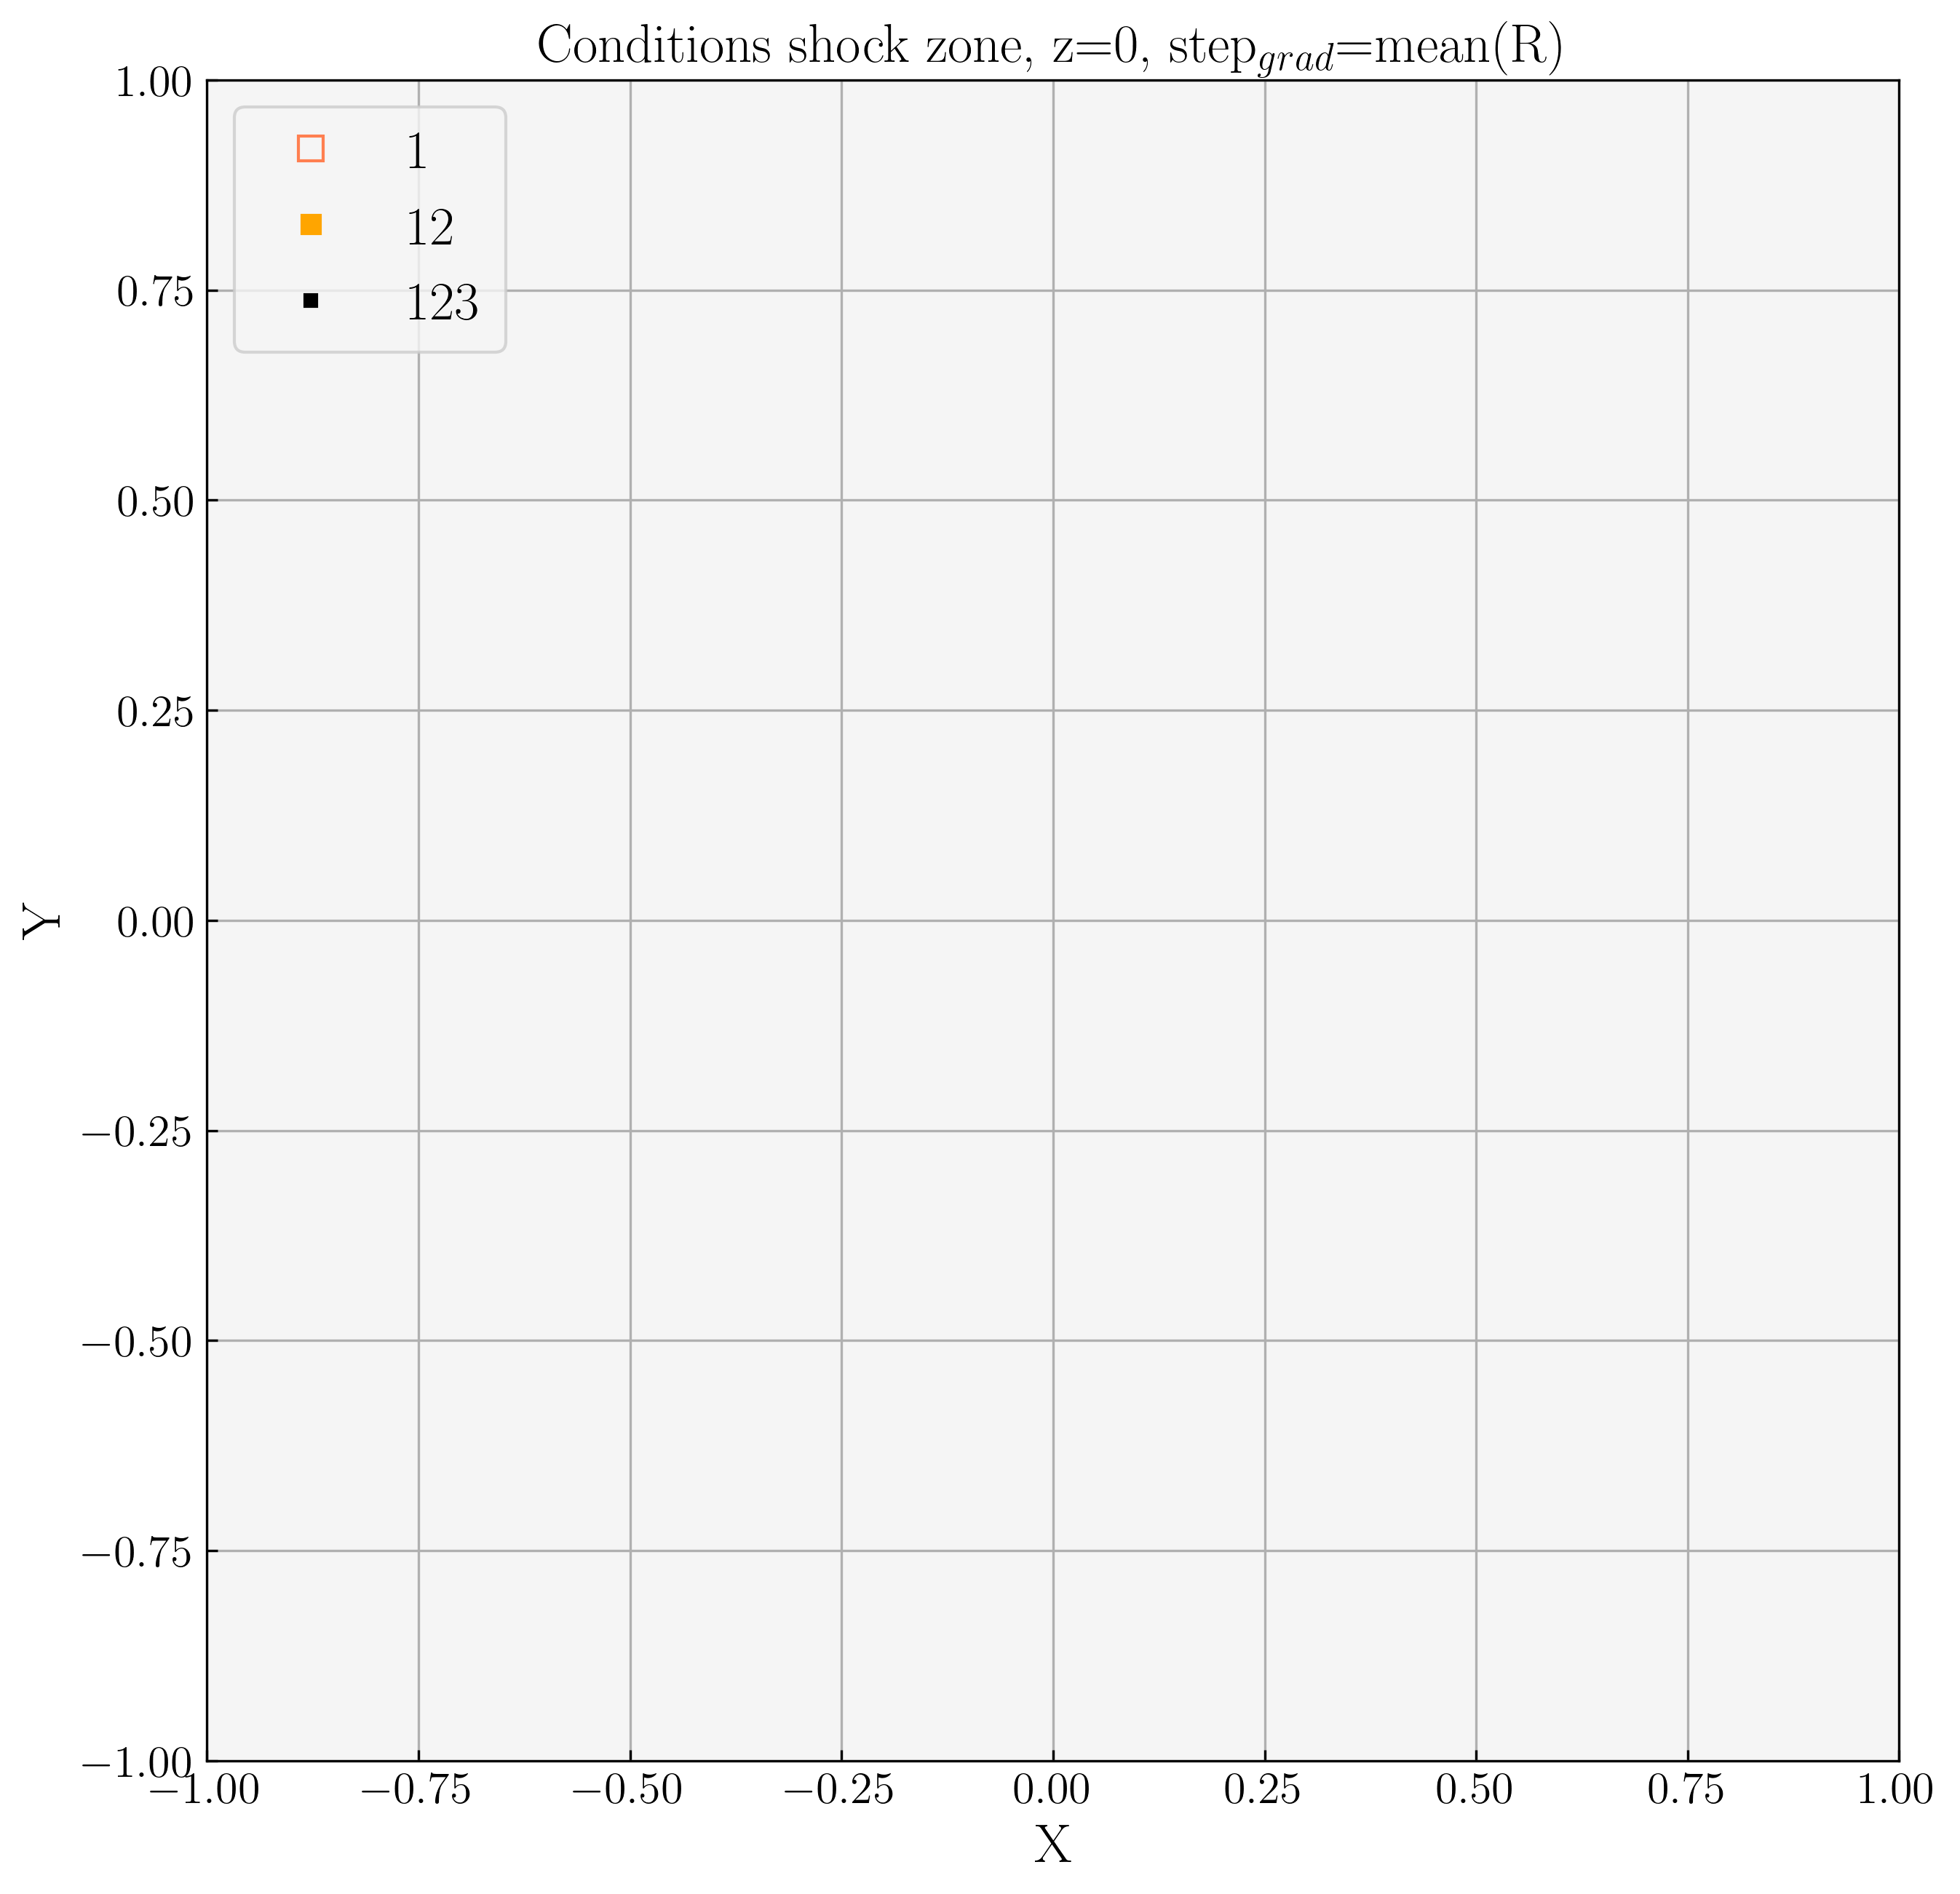

In [ ]:
# Plot 3 conditions (cross section)

plt.figure(figsize=(10,10))
plt.plot(X_shock1[np.abs(Z_shock1)<0.02], Y_shock1[np.abs(Z_shock1)<0.02], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
plt.plot(X_shock2[np.abs(Z_shock2)<0.02], Y_shock2[np.abs(Z_shock2)<0.02], 'ks', c = 'k', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '12')
plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)
plt.grid()
plt.title(r'Conditions shock zone, z=0', fontsize = 18)
if save == True:    
    plt.savefig(f'Figs/3shockzone_conditions_{snap}.png')
plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_7992/202646155.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


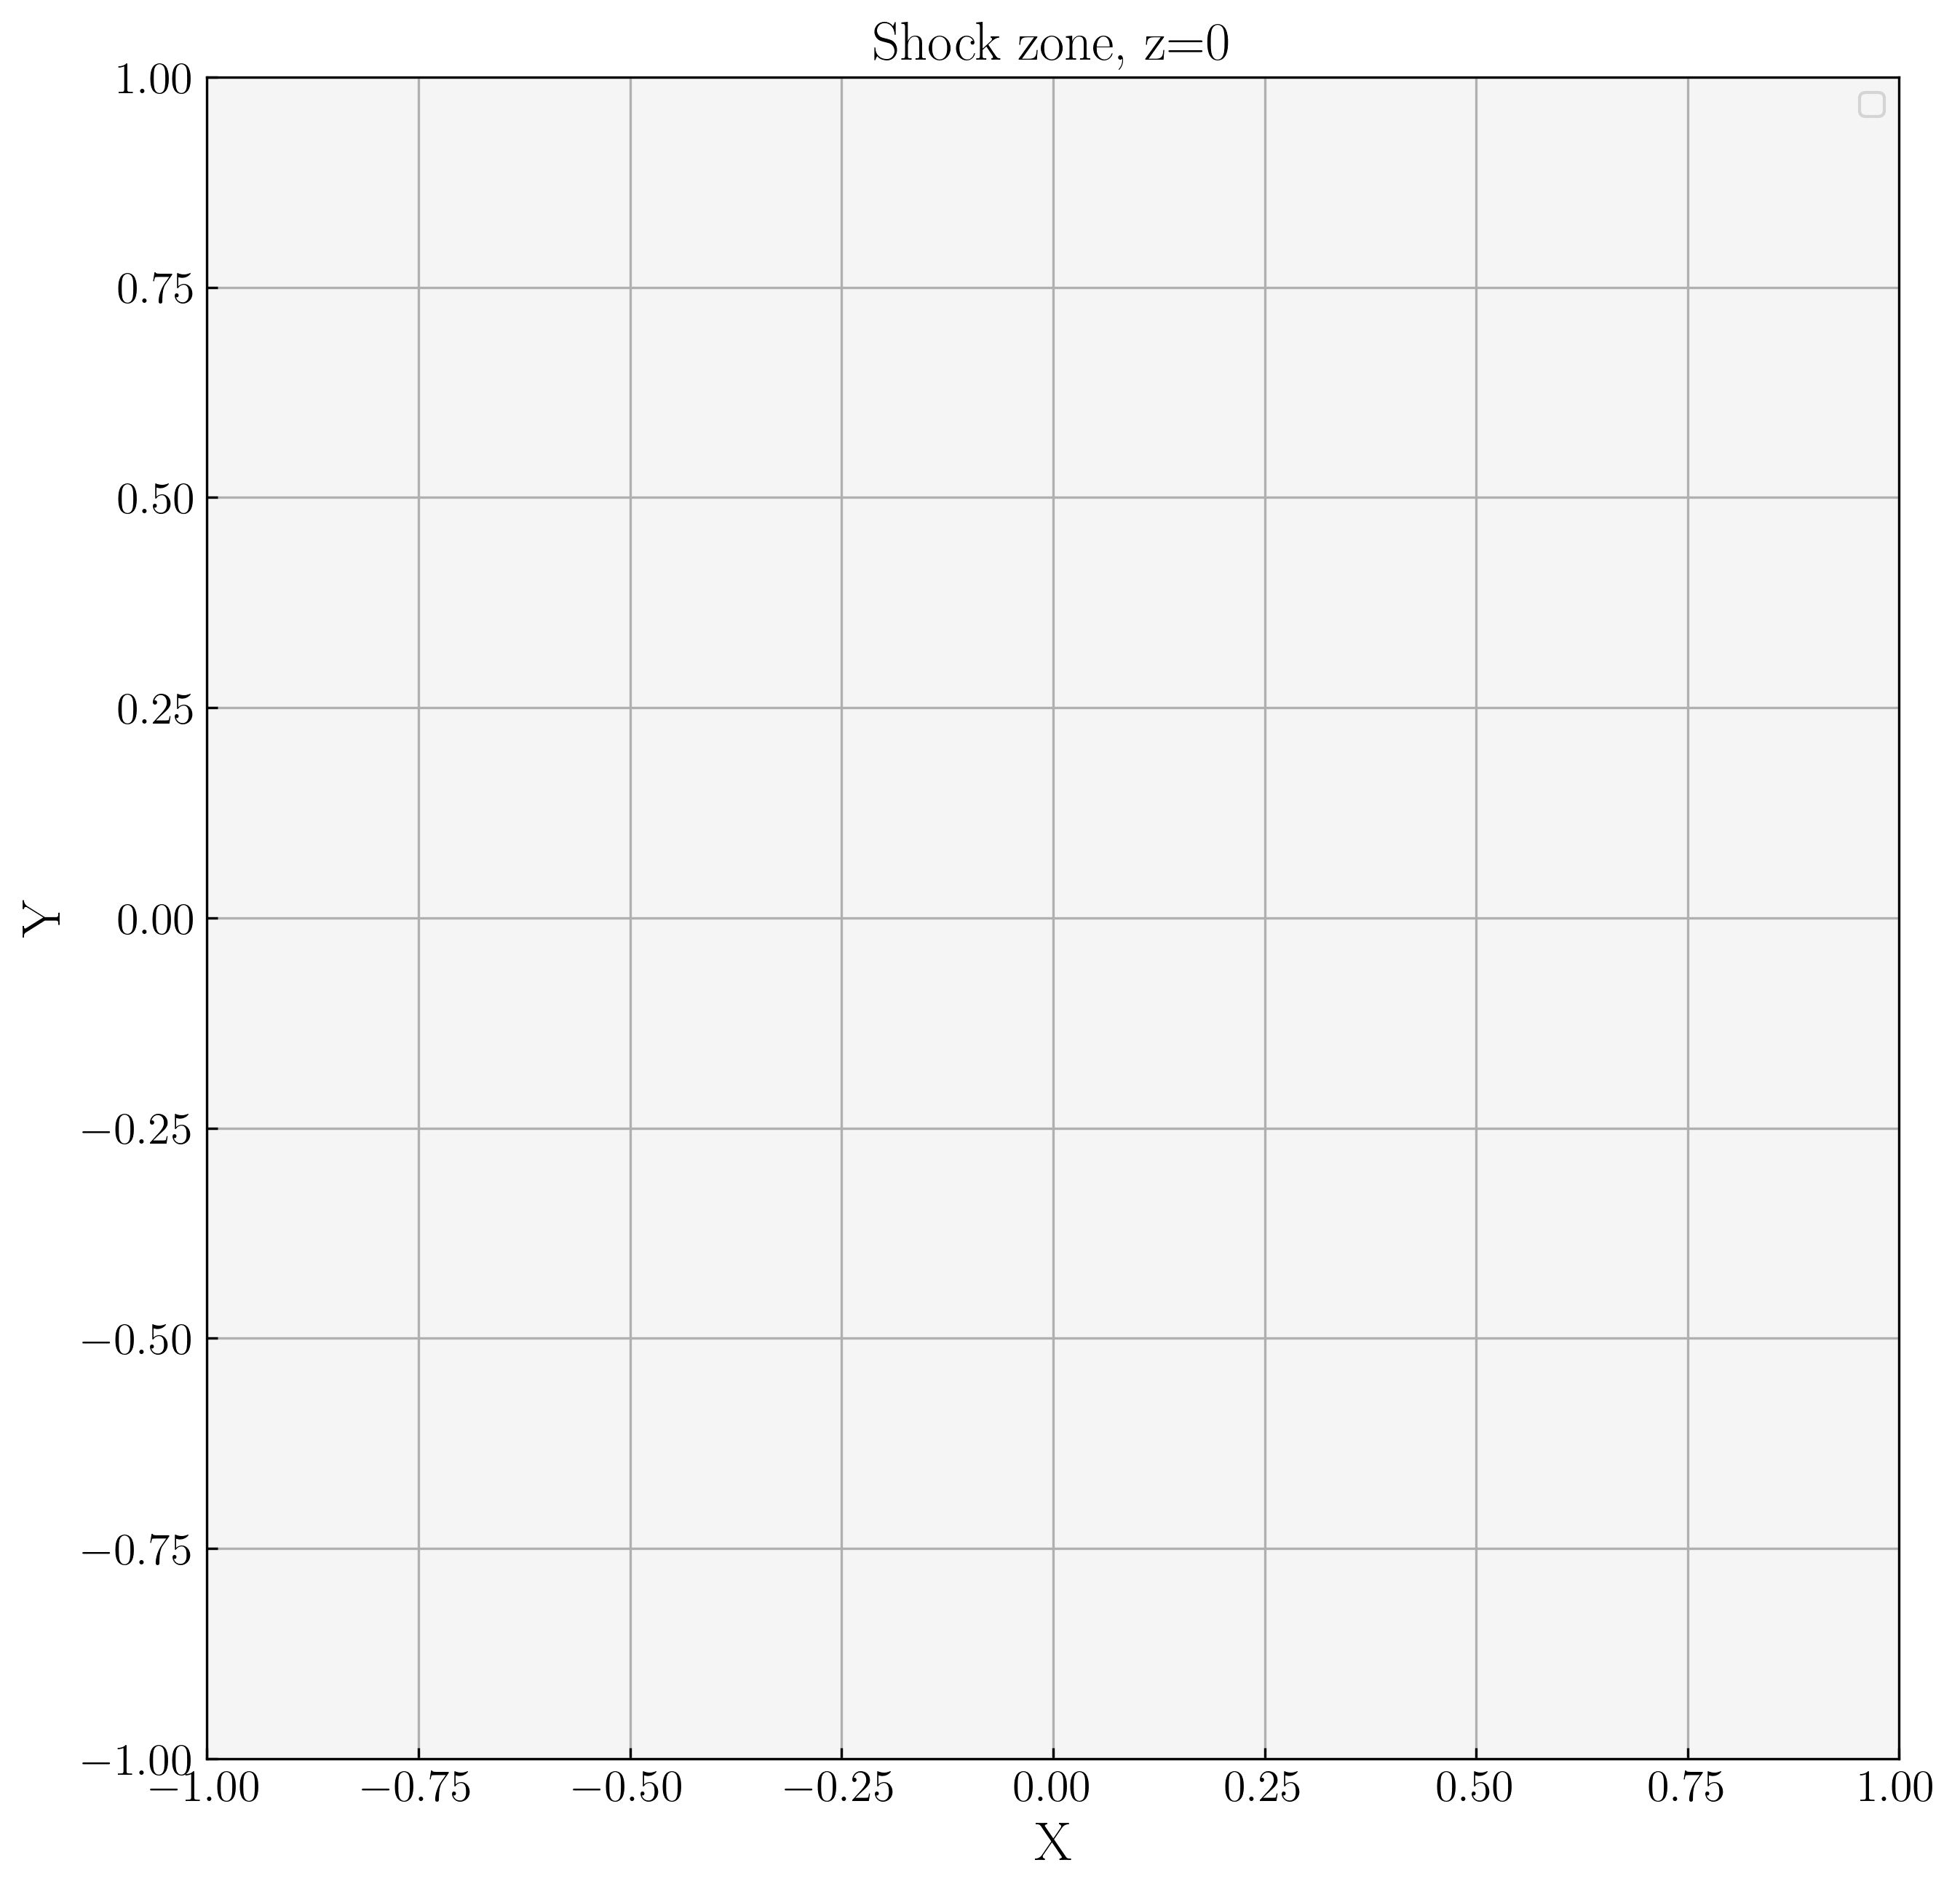

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.legend()
plt.grid()
plt.title('Shock zone, z=0', fontsize = 18)
if save == True: 
    plt.savefig(f'Figs/4shockzone_{snap}.png')
plt.show()

In [ ]:
x_who = np.array(x_who)
y_who = np.array(y_who)
z_who = np.array(z_who)

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_7992/327614014.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')


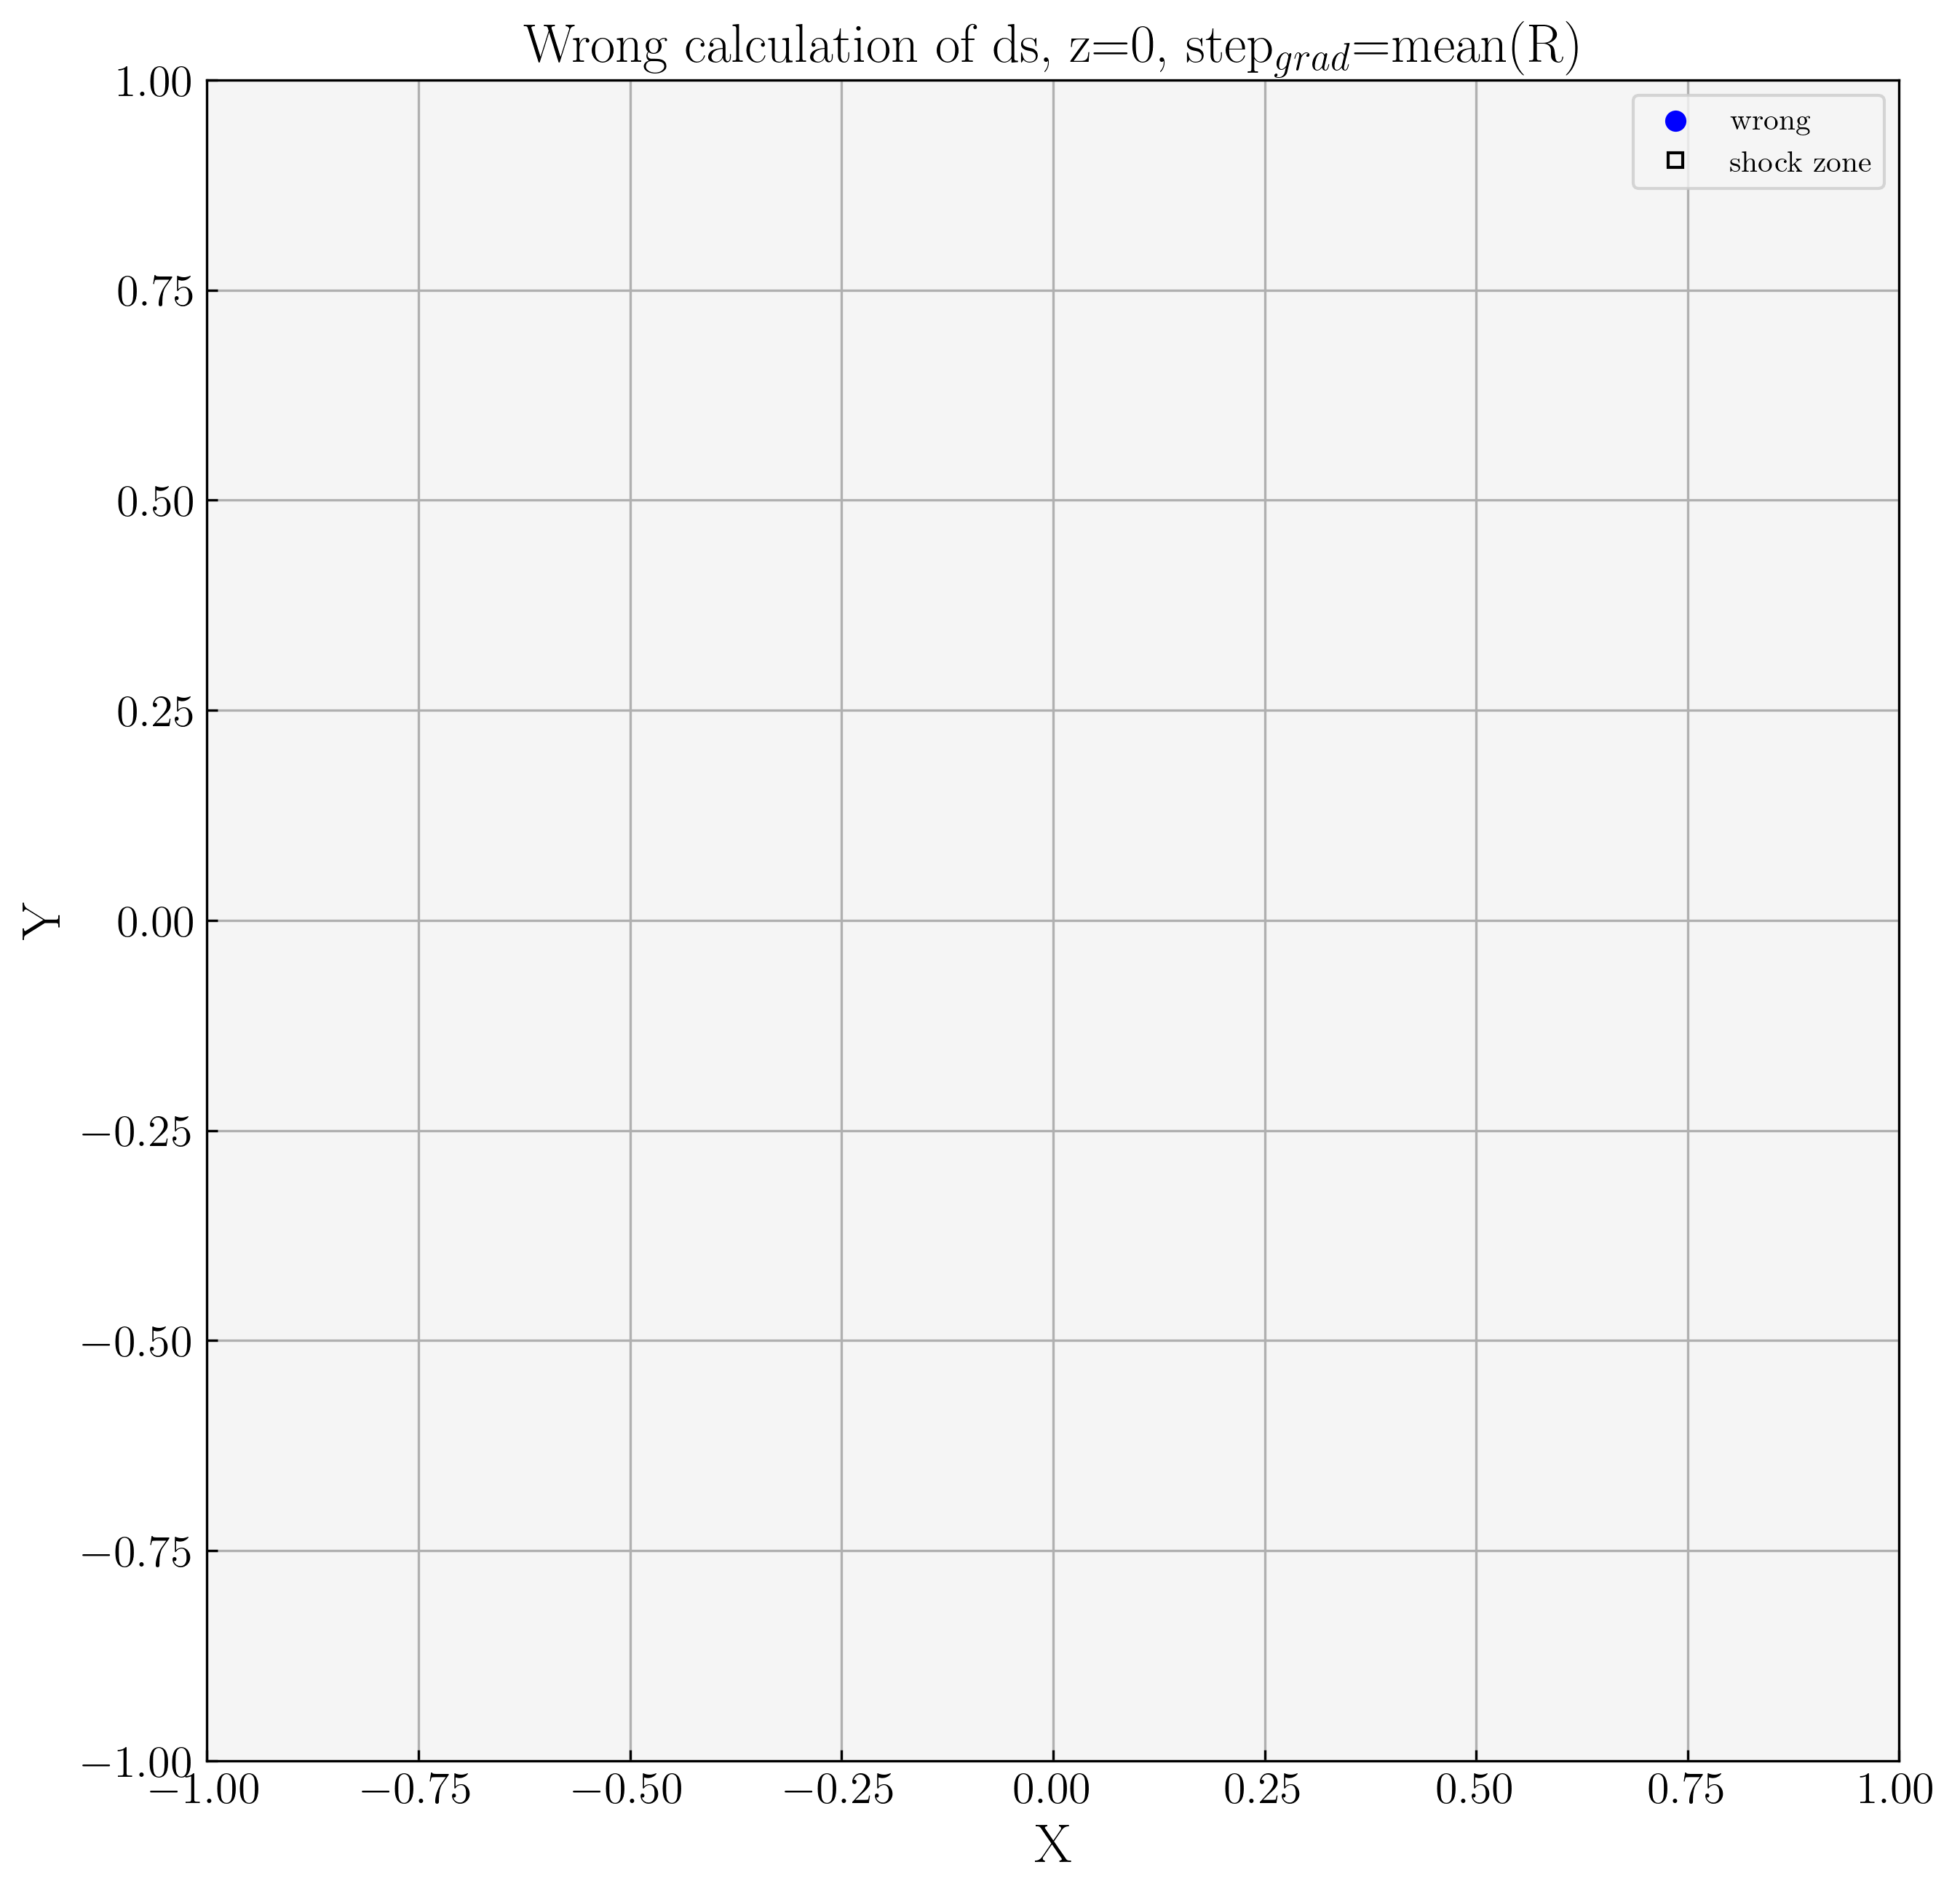

In [ ]:
# plt.figure(figsize=(10,10))
# plt.scatter(x_who[np.abs(z_who)<0.02], y_who[np.abs(z_who)<0.02],  c = 'b', label = 'wrong')
# plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
# plt.xlabel('X', fontsize = 18)
# plt.ylabel('Y', fontsize = 18)
# plt.legend()
# plt.grid()
# plt.title(r'Wrong calculation of ds, z=0, step$_{grad}$=mean(R)', fontsize = 18)
# plt.legend()
# if save:
#     plt.savefig(f'Figs/4who_{snap}.png')
# plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_7992/2802080325.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x/20_000, y/20_000, 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k', label = 'shock zone')


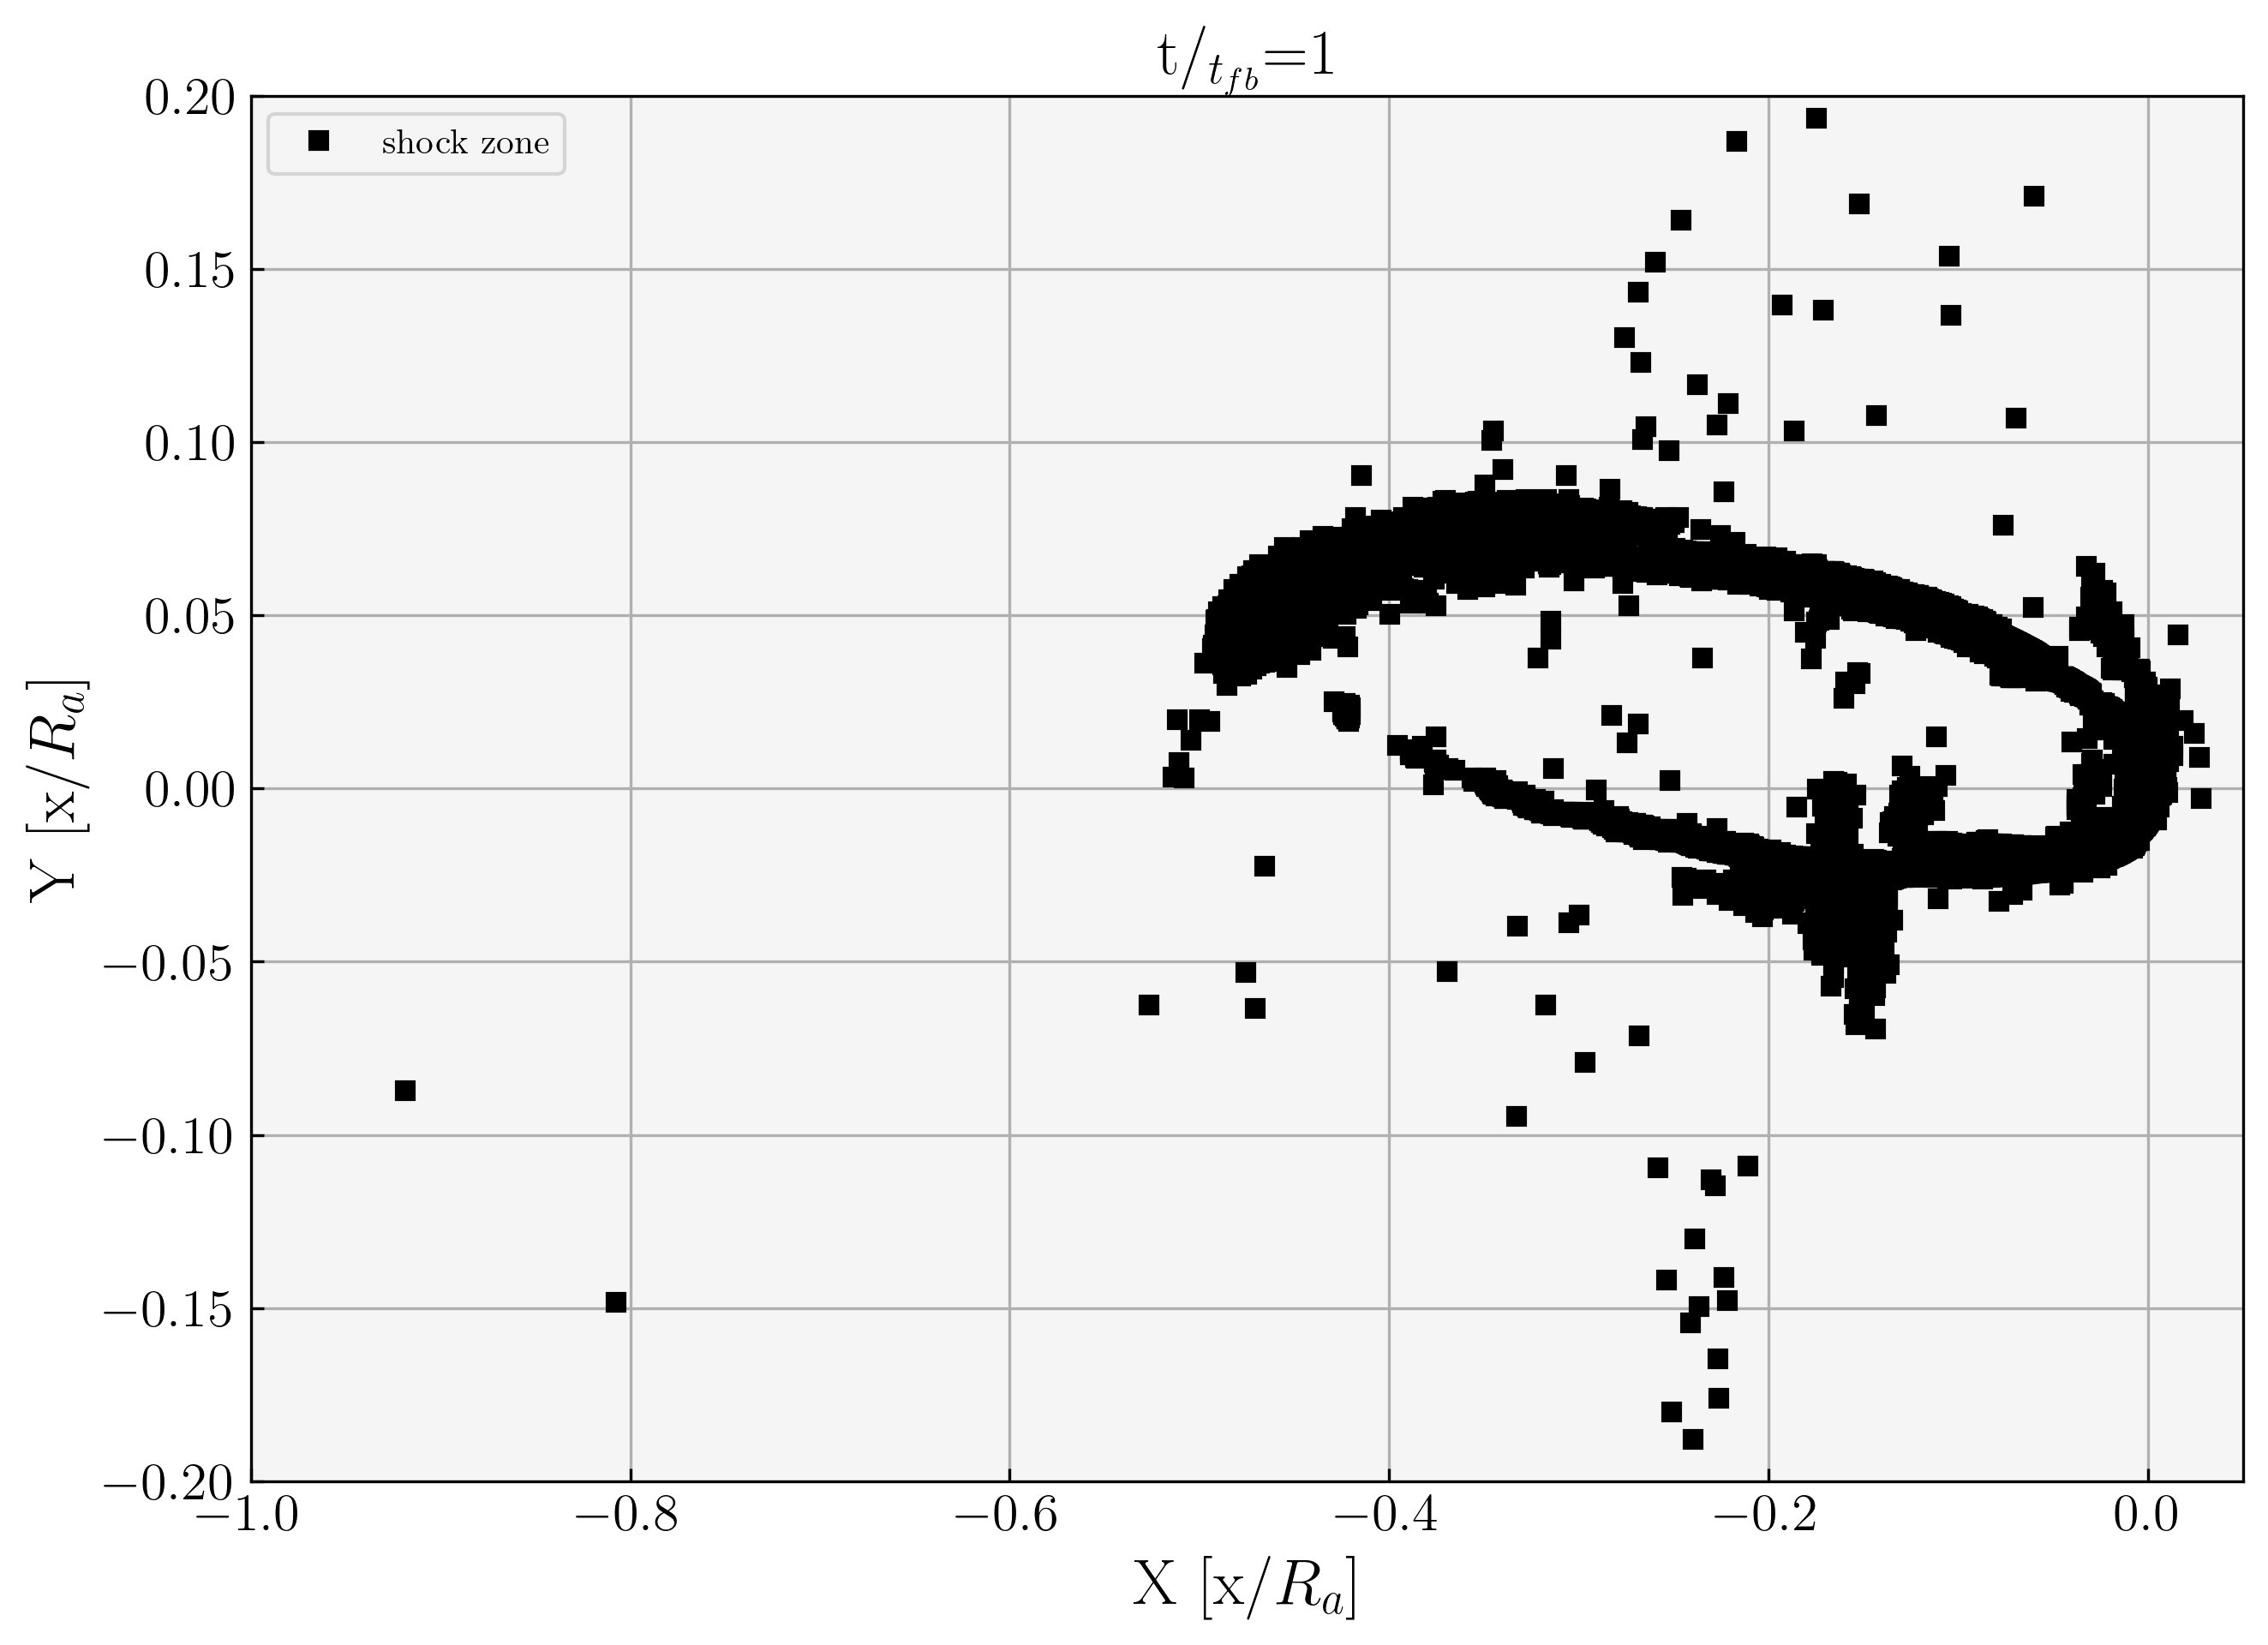

In [ ]:
# for TDE
# data = np.loadtxt('shockzone_844.txt')
x = X_shock #data[0]
y = X_shock #data[1]
plt.figure(figsize=(10,7))
plt.plot(x/20_000, y/20_000, 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k', label = 'shock zone')
plt.xlabel(r'X [x/$R_a$]', fontsize = 18)
plt.ylabel(r'Y [x/$R_a$]', fontsize = 18)
plt.ylim(-0.2, 0.2)
plt.xlim(-1,0.05)
plt.legend()
plt.grid()
plt.title(r't/$_{t_{fb}}$=0.5', fontsize = 18)
#plt.legend()
plt.savefig(f'Figs/683.png')
plt.show()